#Introduction

The aim of this project is to show how football clubs can use player data and their statistical implementations to evaluate an athlete. I will focus on strikers and check which players are the most and the least effective in terms of their suitability for the team. In addition, I will examine how, depending on their own needs, clubs could profile and select players at the scouting and recruitment stage.

The data was downloaded from fbref.com, which provides a free statistics package for the Statsbomb platform.
Taking into account only the forwards, the base had 162 variables and 1031 players from the 5 strongest football leagues (Premier League, La Liga, Serie A, Ligue 1, Bundesliga).

In [1]:
#packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import themepy
import matplotlib.font_manager
from highlight_text import HighlightText, ax_text, fig_text
from IPython.core.display import HTML
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing
import glob
import os

In [2]:
#fonts
def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

In [3]:
#set theme for all plots
theme = themepy.Theme()
theme.set_theme() 

(theme
 .set_font("Open Sans", color="white")
 .set_pips(False)
 .set_spines("off", which=[], color="white") 
 .set_background("#001a4d")
 .set_ticklabel_size(12)
 .set_plot_colors("#DC5349","#26D8FF","#D3CFBD")  
)
theme.add_theme("pavel_dark")
theme.set_theme("pavel_dark")

Theme pavel_dark successfully overwritten


pavel_dark is the active theme

In [4]:
#load files
all_files = glob.glob(os.path.join("...\\Outfield", "*.csv"))
dd= pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
dd.reset_index(drop=True,inplace=True)
dd=dd[dd['position'].str.contains("FW")]
dd.reset_index(drop=True,inplace=True)

In [9]:
#loading data about clubs
ts=pd.read_html("https://fbref.com/en/comps/Big5/2021-2022/stats/squads/2021-2022-Big-5-European-Leagues-Stats")
teams=ts[0]
teams.columns=teams.columns.droplevel()
tms=teams[["Squad","Age",'Min', '90s',"Poss","Gls","Ast"]]
tms.columns=['squad', 'age_TM', 'min_TM', '90s_TM', 'poss_TM', 'gls_TM', 'gls_90_TM', 'ast_TM', 'ast_90_TM']

In [13]:
#df operations
df=pd.merge(dd,tms,on="squad",how="left")
df=df[df["minutes"]>1000]
df.reset_index(drop=True,inplace=True)
top=["Robert Lewandowski","Lionel Messi","Karim Benzema","Cristiano Ronaldo","Mohamed Salah"]
df2=df.loc[df['player'].isin(top)]
df2.reset_index(drop=True,inplace=True)

#Motivation

These simple statistics like goals, assists (even expected goals and expected assists) allow to identify the most effective players, generating "good numbers". However, the question is whether the role of a striker on the pitch should be limited only to scoring goals and assisting?

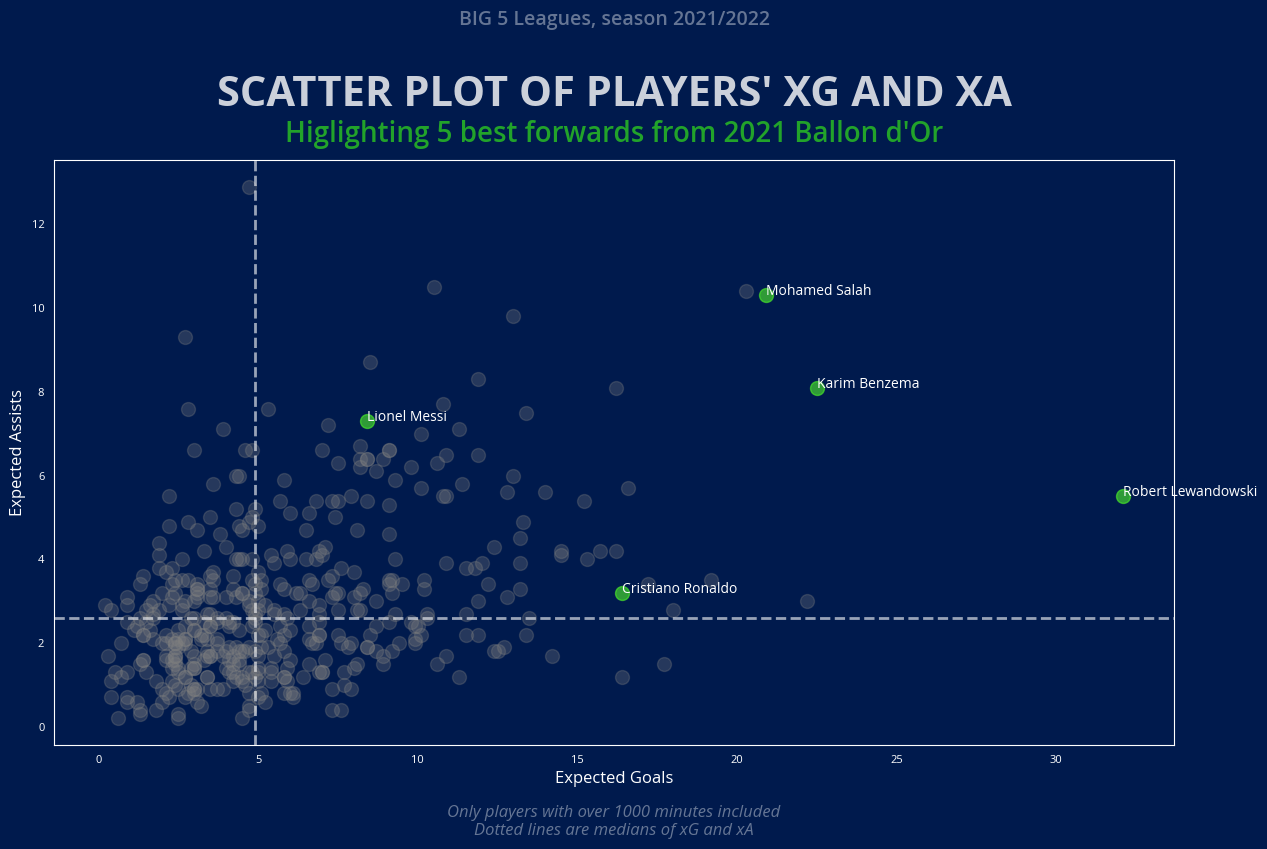

In [12]:
#scatter plot

fig, ax = plt.subplots(figsize=(16,9))

ax.axis('off')

plt.subplots_adjust(left=0.15, bottom=0.15, right=0.85, top=0.8)
grid = plt.GridSpec(1, 1,wspace=0, hspace=0)
ax=fig.add_subplot(grid[:, :])

x=df["xg"]
y=df["xa"]
ax.set_xlabel("Expected Goals",size=12)
ax.set_ylabel("Expected Assists",size=12)
ax.tick_params(labelsize=8)
ax.scatter(x=x,y=y,c="grey",s=100,alpha=0.3)
ax.scatter(x=df2.xg,y=df2.xa,c="#39FF14",s=100,alpha=0.5)

for i, txt in enumerate(df2["player"]):
    ax.annotate(txt, (df2["xg"][i], df2["xa"][i]),size="10")


ax.axvline(x=df["xg"].median(), color='white',zorder=1,ls="--",lw=2,alpha=0.6)
ax.axhline(y=df["xa"].median(), color='white',zorder=1,ls="--",lw=2,alpha=0.6)


fig.text(0.5, 0.95, "BIG 5 Leagues, season 2021/2022", 
                ha = 'center',color = "w", alpha=0.4,
                font={'size':14,'family':"Open Sans","weight":"medium"})
fig.text(0.5, 0.86, "scatter plot of players' xg and xa".upper(), 
                ha = 'center',color = "w", alpha=0.8,
                font={'size':30,'family':"Open Sans","weight":"bold"})
fig.text(0.5, 0.82, "Higlighting 5 best forwards from 2021 Ballon d'Or", 
                ha = 'center',color = "#39FF14", alpha=0.6,
                font={'size':20,'family':"Open Sans","weight":"medium"})

fig.text(0.5, 0.05, "Only players with over 1000 minutes included\nDotted lines are medians of xG and xA", 
                ha = 'center',color = "w", alpha=0.4,
                font={'size':12,"style":"italic"})

fig.savefig("scatter_xg_xa.png",dpi=400)
plt.show()

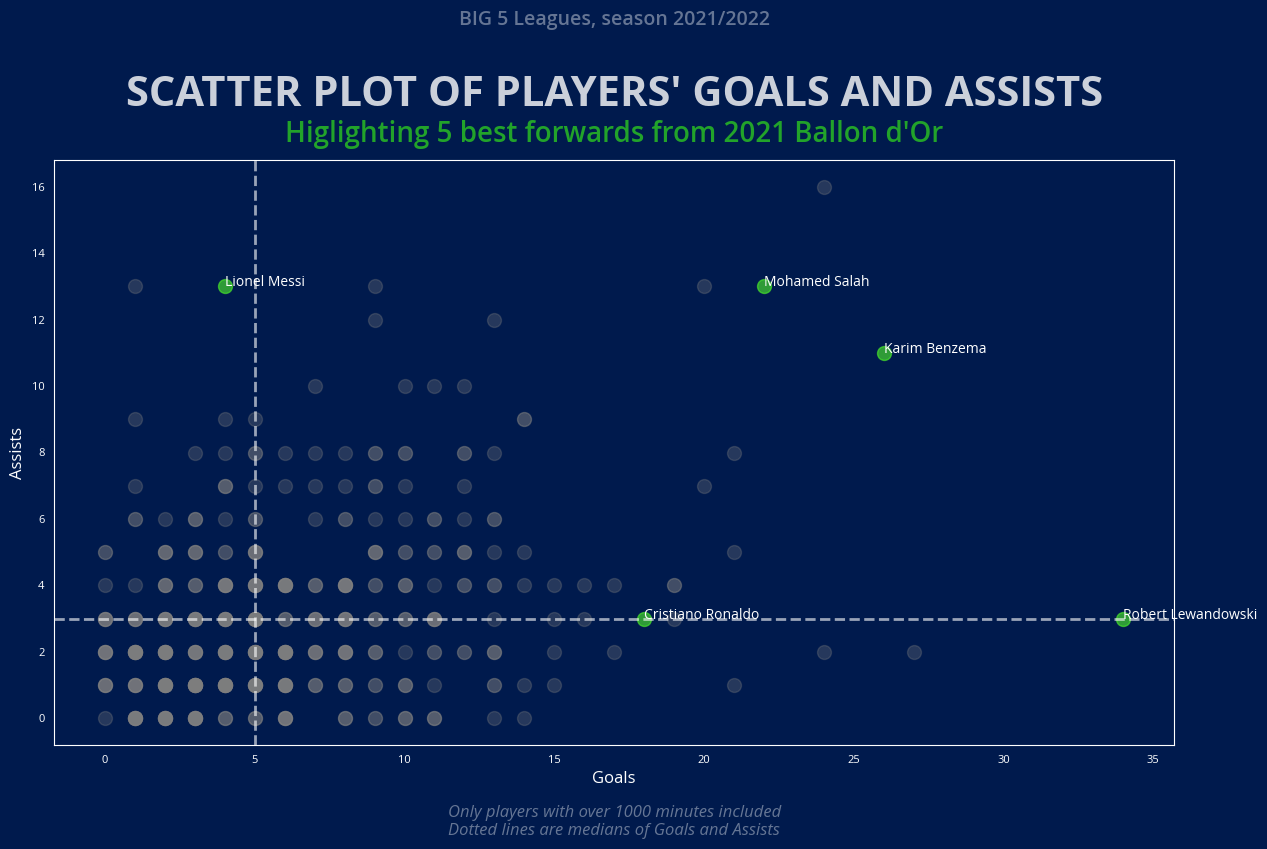

In [14]:
fig, ax = plt.subplots(figsize=(16,9))

ax.axis('off')

plt.subplots_adjust(left=0.15, bottom=0.15, right=0.85, top=0.8)
grid = plt.GridSpec(1, 1,wspace=0, hspace=0)
ax=fig.add_subplot(grid[:, :])

x=df["goals"]
y=df["assists"]
ax.set_xlabel("Goals",size=12)
ax.set_ylabel("Assists",size=12)
ax.tick_params(labelsize=8)
ax.scatter(x=x,y=y,c="grey",s=100,alpha=0.3)
ax.scatter(x=df2.goals,y=df2.assists,c="#39FF14",s=100,alpha=0.5)

for i, txt in enumerate(df2["player"]):
    ax.annotate(txt, (df2["goals"][i], df2["assists"][i]),size="10")


ax.axvline(x=df["goals"].median(), color='white',zorder=1,ls="--",lw=2,alpha=0.6)
ax.axhline(y=df["assists"].median(), color='white',zorder=1,ls="--",lw=2,alpha=0.6)


fig.text(0.5, 0.95, "BIG 5 Leagues, season 2021/2022", 
                ha = 'center',color = "w", alpha=0.4,
                font={'size':14,'family':"Open Sans","weight":"medium"})
fig.text(0.5, 0.86, "scatter plot of players' goals and assists".upper(), 
                ha = 'center',color = "w", alpha=0.8,
                font={'size':30,'family':"Open Sans","weight":"bold"})
fig.text(0.5, 0.82, "Higlighting 5 best forwards from 2021 Ballon d'Or", 
                ha = 'center',color = "#39FF14", alpha=0.6,
                font={'size':20,'family':"Open Sans","weight":"medium"})

fig.text(0.5, 0.05, "Only players with over 1000 minutes included\nDotted lines are medians of Goals and Assists", 
                ha = 'center',color = "w", alpha=0.4,
                font={'size':12,"style":"italic"})

fig.savefig("scatter_g_a.png",dpi=400)
plt.show()

In [15]:
#preparing data
jesus=pd.read_html("https://fbref.com/en/players/b66315ae/matchlogs/2021-2022/summary/Gabriel-Jesus-Match-Logs")
js=jesus[0]
js.columns=js.columns.droplevel()
js=js[["Gls","xG"]]
js=js.dropna()
js = js[js["xG"].str.contains("On matchday squad, but did not play") == False]
js["xG"]=pd.to_numeric(js["xG"])
js["Gls"]=pd.to_numeric(js["Gls"])
js.reset_index(drop=True,inplace=True)
js["diff"]=js["Gls"]-js["xG"]
js["diff_MA5"]=js["diff"].rolling(5).mean()
js["sum"]=js["diff_MA5"].cumsum()
js=js.iloc[:-1]
heung=pd.read_html("https://fbref.com/en/players/92e7e919/matchlogs/2021-2022/summary/Son-Heung-min-Match-Logs")
hms=heung[0]
hms.columns=hms.columns.droplevel()
hms=hms[["Gls","xG"]]
hms=hms.dropna()
hms.reset_index(drop=True,inplace=True)
hms["diff"]=hms.Gls-hms.xG
hms["diff_MA5"]=hms["diff"].rolling(5).mean()
hms["sum"]=hms["diff_MA5"].cumsum()
hms=hms.iloc[:-1]
hms.head()

,Gls,xG,diff,diff_MA5,sum
0,1.0,0.2,0.8,NaN,NaN
1,0.0,0.2,-0.2,NaN,NaN
2,1.0,0.2,0.8,NaN,NaN
3,0.0,0.3,-0.3,NaN,NaN
4,1.0,0.3,0.7,0.36,0.36


#Son vs Jesus

Little example. As you can see on the chart below, the Korean showed great efficiency throughout the previous season (he was the best in the league in this area). The situation was different for Jesus, who was much less efficient. However, the coaches and scouts recognize both of them as the league's leading forwards, which was confirmed by the transfer of the Brazilian to the Arsenal for nearly 50 million pounds.

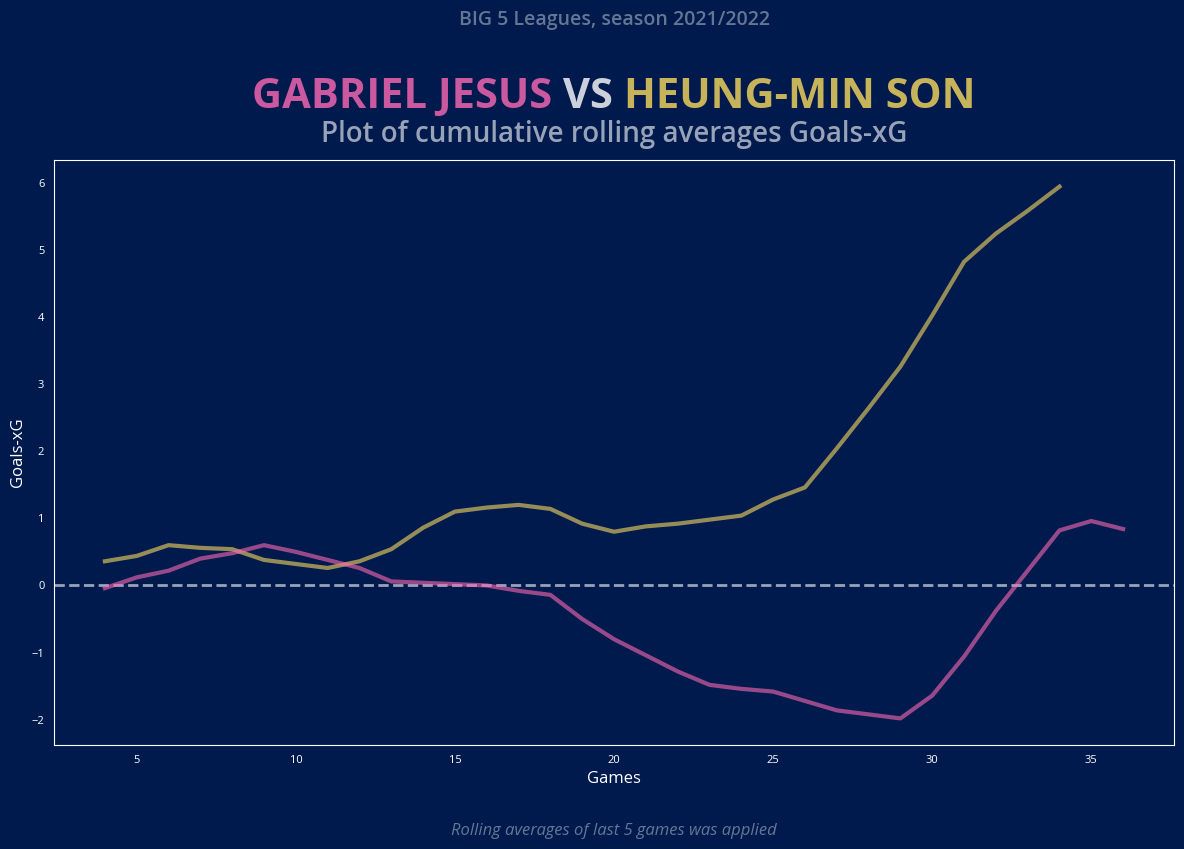

In [16]:
#comaparison line plot
fig, ax = plt.subplots(figsize=(16,9))

ax.axis('off')
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.85, top=0.8)
grid = plt.GridSpec(1, 1,wspace=0, hspace=0)
ax=fig.add_subplot(grid[:, :])

x=hms.index.values
y=hms["sum"]
ax.plot(x, y,c="#FADA5E",alpha=0.6,linewidth=3,zorder=4)
x=js.index.values
y=js["sum"]
ax.plot(x, y,c="#FF69B4",alpha=0.6,linewidth=3,zorder=4)
ax.axhline(y=0, color='white',zorder=1,ls="--",lw=2,alpha=0.6)

ax.set_xlabel("Games", fontsize=12)
ax.set_ylabel("Goals-xG", fontsize=12)
ax.tick_params(labelsize=8)

transform = ax.transAxes
fig.text(0.5, 0.95, "BIG 5 Leagues, season 2021/2022", 
                ha = 'center',color = "w", alpha=0.4,
                font={'size':14,'family':"Open Sans","weight":"medium"})
fig_text(x = 0.5, y = 0.87,s="<GABRIEL JESUS ><VS ><HEUNG-MIN SON>",ha='center', va='center',
highlight_textprops=[{"color": "#FF69B4",'size':30,'family':"Open Sans","weight":"bold","alpha":0.8},
                {"color": "w",'size':30,'family':"Open Sans","weight":"bold","alpha":0.8},
                {"color": '#FADA5E','size':30,'family':"Open Sans","weight":"bold","alpha":0.8}])
fig.text(0.5, 0.82, "Plot of cumulative rolling averages Goals-xG", 
                ha = 'center',color = "w", alpha=0.6,
                font={'size':20,'family':"Open Sans","weight":"medium"})
fig.text(0.5, 0.05, "Rolling averages of last 5 games was applied", 
                ha = 'center',color = "w", alpha=0.4,
                font={'size':12,"style":"italic"})

fig.savefig("son_jesus.png",dpi=400)
plt.show()

In [17]:
df=df[['player',"minutes",'xg', 'xa', 'shots_on_target','passes_completed','crosses_into_penalty_area', 'progressive_passes','sca', 'tackles_att_3rd', 'pressures_att_3rd', 'touches_att_3rd', 'dribbles_completed',  'carries_into_final_third','passes_received', 'fouled',  'aerials_won']]
df=df[df["minutes"]>2750]
df = df.fillna(df.mean())
names = df.player.tolist()
df = df.drop(['player'], axis = 1)
df = df.drop(['minutes'], axis = 1)
df.head()

C:\Users\Paweł Zajdel\AppData\Local\Temp\ipykernel_19872\3527094555.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df.fillna(df.mean())


,xg,xa,shots_on_target,passes_completed,crosses_into_penalty_area,progressive_passes,sca,tackles_att_3rd,pressures_att_3rd,touches_att_3rd,dribbles_completed,carries_into_final_third,passes_received,fouled,aerials_won
43,32.1,5.5,74.0,570.0,3.0,53.0,99.0,6.0,206.0,689.0,33.0,24.0,901.0,44.0,69.0
88,13.0,6.0,34.0,920.0,8.0,72.0,105.0,7.0,194.0,915.0,34.0,60.0,1231.0,60.0,34.0
124,12.0,3.9,32.0,673.0,4.0,78.0,71.0,5.0,224.0,640.0,16.0,7.0,1146.0,60.0,307.0
156,3.1,4.7,15.0,544.0,10.0,57.0,80.0,9.0,128.0,714.0,63.0,70.0,839.0,43.0,25.0
158,2.6,2.9,9.0,726.0,1.0,70.0,80.0,10.0,153.0,544.0,55.0,45.0,899.0,78.0,46.0


#Clustering

Having in mind the above-mentioned aspects, I decided to conduct an analysis that will allow us to distinguish different types of attackers, as well as search for players similar in terms of their style of play.

I decided to use cluster analysis methods for this purpose, precisely the k-means method.
I standardized all the variables to get rid of the problem of different units.
Subsequently PCA, I reduced the number of dimensions to two.

In [18]:
x = df.values 
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)
X_norm = pd.DataFrame(x_scaled)

In [19]:
pca = PCA(n_components = 2) 
reduced = pd.DataFrame(pca.fit_transform(X_norm))
kmeans = KMeans(n_clusters=4)
kmeans = kmeans.fit(reduced)
labels = kmeans.predict(reduced)
centroid = kmeans.cluster_centers_
clusters = kmeans.labels_.tolist()
reduced['cluster'] = clusters
reduced['name'] = names
reduced.columns = ['x', 'y', 'cluster', 'name']
reduced.head()

,x,y,cluster,name
0,-0.254517,0.926841,1,Robert Lewandowski
1,0.340374,0.133190,1,Iago Aspas
2,-0.402746,0.028527,0,Joselu
3,-0.005002,-0.273925,3,Luis Rioja
4,-0.275027,-0.421404,3,Dani Rodríguez


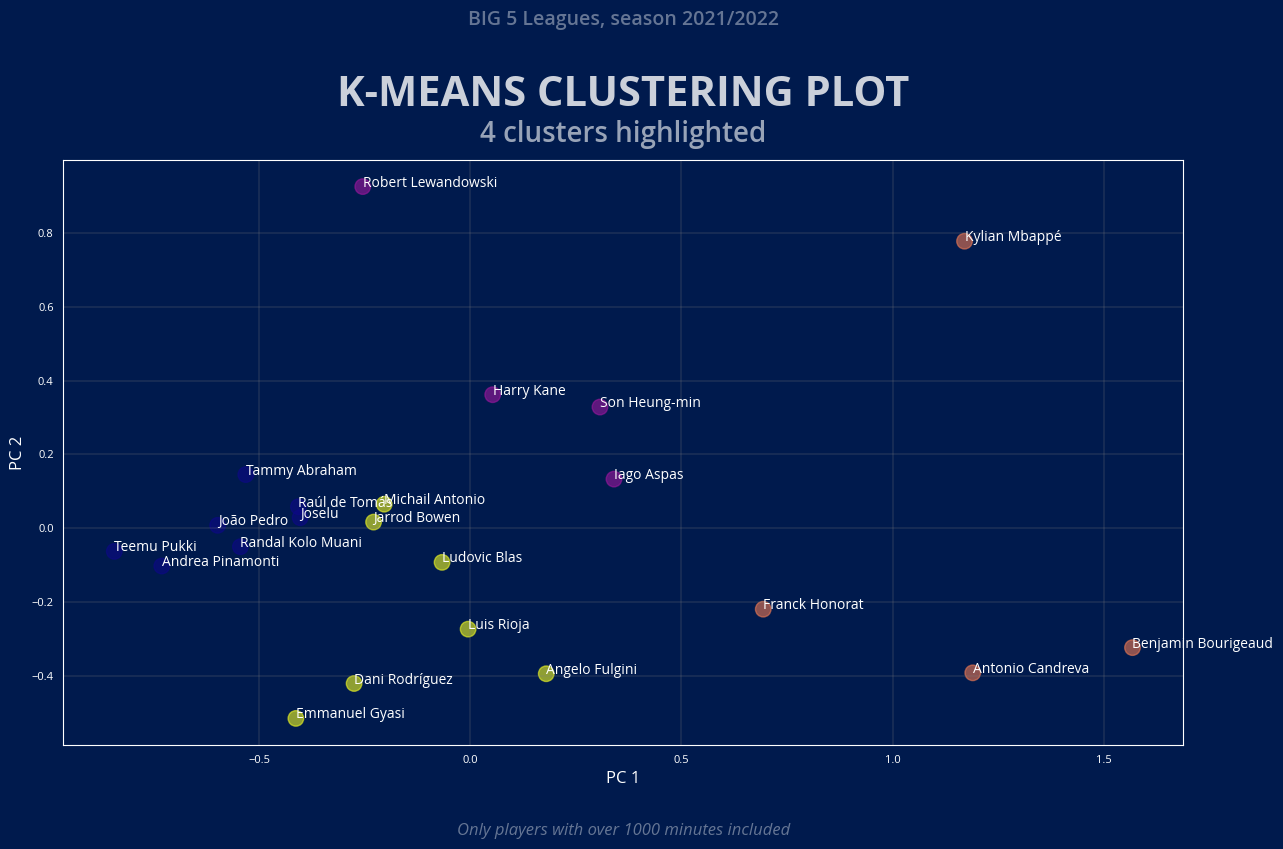

In [20]:

fig, ax = plt.subplots(figsize=(16,9))

ax.axis('off')
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.85, top=0.8)
grid = plt.GridSpec(1, 1,wspace=0, hspace=0)
ax=fig.add_subplot(grid[:, :])
ax.grid(linewidth=.25, zorder=3, color="grey")
ax.scatter(reduced["x"],reduced["y"],c=reduced["cluster"],cmap="plasma",s=125,alpha=0.6)
texts = []
for x, y, s in zip(reduced.x, reduced.y, reduced.name):
    texts.append(plt.text(x, y, s))
ax.tick_params(labelsize=8)
ax.set_xlabel("PC 1", fontsize = 12)
ax.set_ylabel("PC 2", fontsize = 12)
fig.text(0.5, 0.95, "BIG 5 Leagues, season 2021/2022", 
                ha = 'center',color = "w", alpha=0.4,
                font={'size':14,'family':"Open Sans","weight":"medium"})
fig.text(0.5, 0.86, "K-means clustering plot".upper(), 
                ha = 'center',color = "w", alpha=0.8,
                font={'size':30,'family':"Open Sans","weight":"bold"})
fig.text(0.5, 0.82, "4 clusters highlighted", 
                ha = 'center',color = "w", alpha=0.6,
                font={'size':20,'family':"Open Sans","weight":"medium"})
fig.text(0.5, 0.05, "Only players with over 1000 minutes included", 
                ha = 'center',color = "w", alpha=0.4,
                font={'size':12,"style":"italic"})
fig.savefig("kmeans_4clusters.png",dpi=400)
plt.show()

In [21]:
pca = PCA(n_components = 2) 
reduced = pd.DataFrame(pca.fit_transform(X_norm))
kmeans = KMeans(n_clusters=3)
kmeans = kmeans.fit(reduced)
labels = kmeans.predict(reduced)
centroid = kmeans.cluster_centers_
clusters = kmeans.labels_.tolist()
reduced['cluster'] = clusters
reduced['name'] = names
reduced.columns = ['x', 'y', 'cluster', 'name']
reduced.head()

,x,y,cluster,name
0,-0.254517,0.926841,2,Robert Lewandowski
1,0.340374,0.133190,2,Iago Aspas
2,-0.402746,0.028527,1,Joselu
3,-0.005002,-0.273925,1,Luis Rioja
4,-0.275027,-0.421404,1,Dani Rodríguez


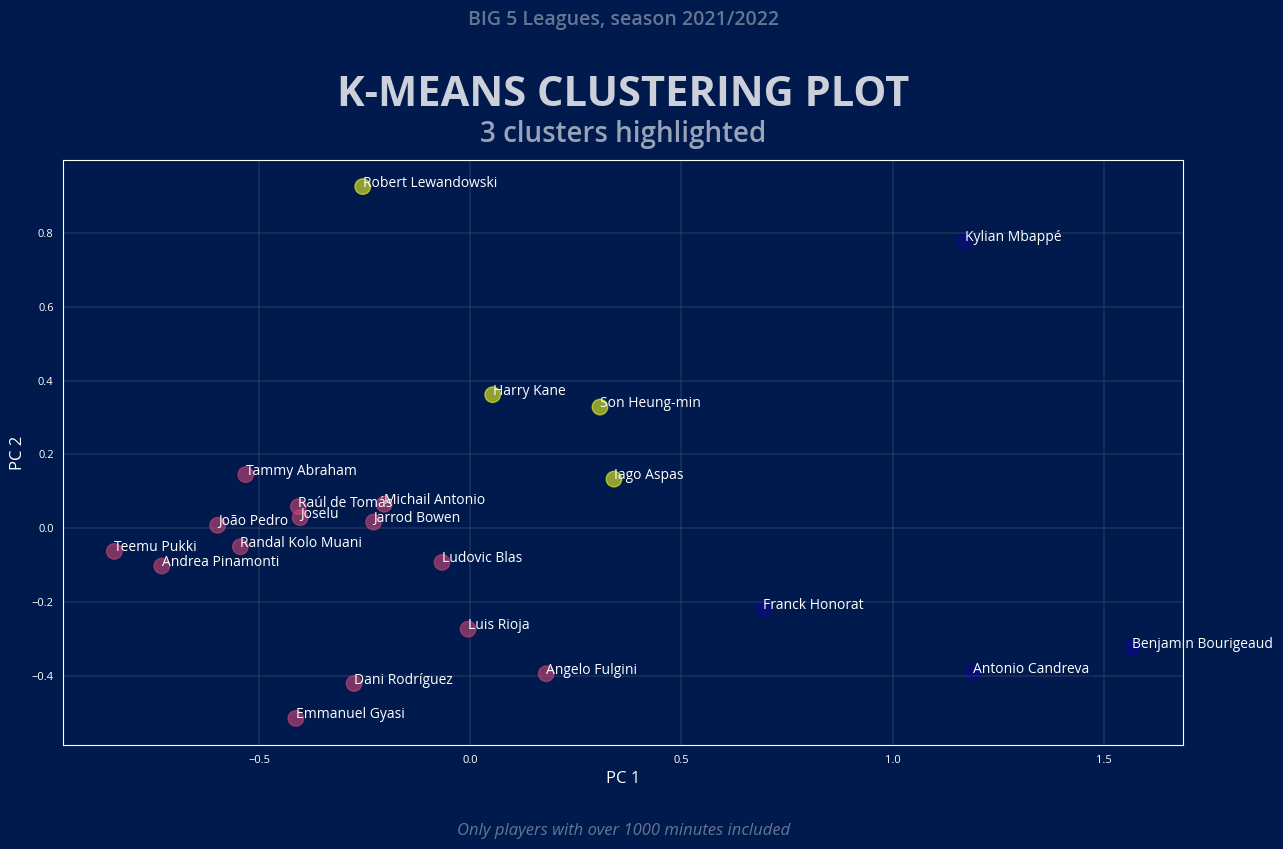

In [22]:

fig, ax = plt.subplots(figsize=(16,9))

ax.axis('off')
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.85, top=0.8)
grid = plt.GridSpec(1, 1,wspace=0, hspace=0)
ax=fig.add_subplot(grid[:, :])
ax.grid(linewidth=.25, zorder=3, color="grey")
ax.scatter(reduced["x"],reduced["y"],c=reduced["cluster"],cmap="plasma",s=125,alpha=0.6)
texts = []
for x, y, s in zip(reduced.x, reduced.y, reduced.name):
    texts.append(plt.text(x, y, s))
ax.tick_params(labelsize=8)
ax.set_xlabel("PC 1", fontsize = 12)
ax.set_ylabel("PC 2", fontsize = 12)
fig.text(0.5, 0.95, "BIG 5 Leagues, season 2021/2022", 
                ha = 'center',color = "w", alpha=0.4,
                font={'size':14,'family':"Open Sans","weight":"medium"})
fig.text(0.5, 0.86, "K-means clustering plot".upper(), 
                ha = 'center',color = "w", alpha=0.8,
                font={'size':30,'family':"Open Sans","weight":"bold"})
fig.text(0.5, 0.82, "3 clusters highlighted", 
                ha = 'center',color = "w", alpha=0.6,
                font={'size':20,'family':"Open Sans","weight":"medium"})
fig.text(0.5, 0.05, "Only players with over 1000 minutes included", 
                ha = 'center',color = "w", alpha=0.4,
                font={'size':12,"style":"italic"})
fig.savefig("kmeans_3clusters.png",dpi=400)
plt.show()

#Results

The k-means method made it possible to distinguish groups of players with similar skillsets, the values of the OY axis could be interpreted as egoism, or colloquially "goal hunger", while the values of the OX axis differentiate players due to altruism, the ability to cooperate related to passing or crosses. It can therefore be concluded that the algorithm proposed three groups of attackers: offensive in the strict sense, balanced and cooperating.
When looking at the graphs it seems more logical to use 3 clusters. In the case of 4 clusters, there was only an additional focus with a few outliers, they are the best attackers, so it is not an assignment to the style of the game, and the skills which they definitely stand out from the others.

#Comparisons

To better visualize the different types of players, I made two dumbbell plots. 
Firstly I compared players from two different distant clusters: Robert Lewandowski and Antonio Candreva. The Pole, despite great shooting statistics, is significantly losing ground in other areas. The Italian is more versatile and belongs to the type of more modern attackers.
Next I put together players from one group, very close to each other (Antonio Candreva-Benjamin Bourigeaud). In this case, the differences are much smaller, both players play in a similar style and could be their worthy replacement.

In [23]:
temp=X_norm
temp['name'] = names
temp=temp.loc[temp['name'].isin(["Antonio Candreva","Robert Lewandowski"])]
temp=temp.T
temp.columns = temp.iloc[-1]
temp = temp.drop(['name'], axis = 0) 
temp['stat'] = df.columns
temp=temp.sort_values(by="Robert Lewandowski",ascending=False)
range_tmp=range(1,len(temp.index)+1)
temp.head()

name,Robert Lewandowski,Antonio Candreva,stat
0,1.0,0.108475,xg
2,1.0,0.153846,shots_on_target
13,0.435897,0.448718,fouled
8,0.428571,0.050193,pressures_att_3rd
6,0.426087,0.6,sca


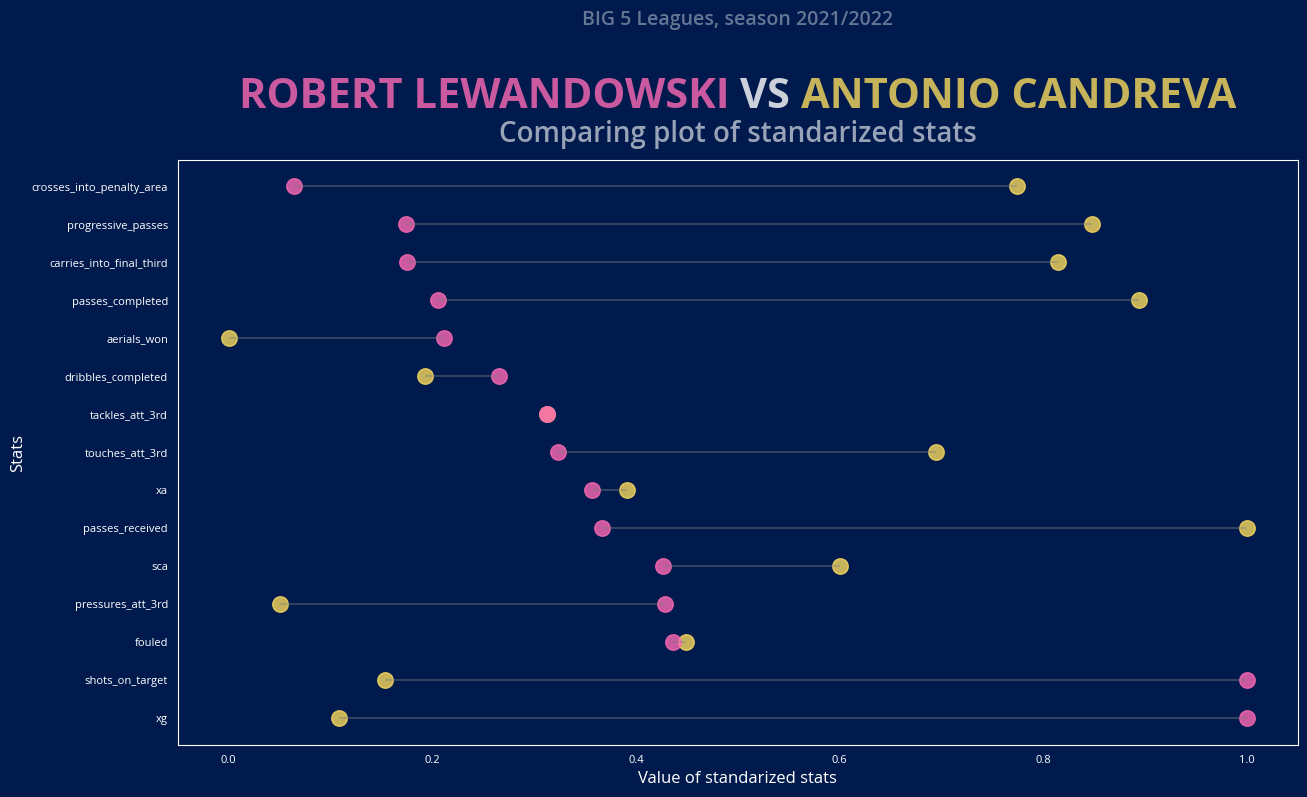

In [24]:
fig, ax = plt.subplots(figsize=(16,9))

ax.axis('off')
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.85, top=0.8)
grid = plt.GridSpec(1, 1,wspace=0, hspace=0)
ax=fig.add_subplot(grid[:, :])
ax.hlines(y=range_tmp,xmax=temp["Antonio Candreva"],xmin=temp["Robert Lewandowski"],color="grey",alpha=0.4)
ax.scatter(temp["Antonio Candreva"],range_tmp,color="#FADA5E",s=125,alpha=0.8)
ax.scatter(temp["Robert Lewandowski"],range_tmp,color="#FF69B4",s=125,alpha=0.8)
ax.tick_params(labelsize=8)
ax.set_yticks(range_tmp, temp['stat'])
ax.set_xlabel("Value of standarized stats", fontsize = 12)
ax.set_ylabel("Stats", fontsize = 12)
transform = ax.transAxes
fig.text(0.5, 0.95, "BIG 5 Leagues, season 2021/2022", 
                ha = 'center',color = "w", alpha=0.4,
                font={'size':14,'family':"Open Sans","weight":"medium"})
fig_text(x = 0.5, y = 0.87,s="<ROBERT LEWANDOWSKI ><VS ><ANTONIO CANDREVA>",ha='center', va='center',
highlight_textprops=[{"color": "#FF69B4",'size':30,'family':"Open Sans","weight":"bold","alpha":0.8},
                {"color": "w",'size':30,'family':"Open Sans","weight":"bold","alpha":0.8},
                {"color": '#FADA5E','size':30,'family':"Open Sans","weight":"bold","alpha":0.8}])
fig.text(0.5, 0.82, "Comparing plot of standarized stats", 
                ha = 'center',color = "w", alpha=0.6,
                font={'size':20,'family':"Open Sans","weight":"medium"})
fig.savefig("lewy_candreva.png",dpi=400)
plt.show()

In [26]:
temp=X_norm
temp['name'] = names
temp=temp.loc[temp['name'].isin(["Antonio Candreva","Benjamin Bourigeaud"])]
temp=temp.T
temp.columns = temp.iloc[-1]
temp = temp.drop(['name'], axis = 0) 
temp['stat'] = df.columns
temp=temp.sort_values(by="Benjamin Bourigeaud",ascending=False)
range_tmp=range(1,len(temp.index)+1)
temp.head()

name,Benjamin Bourigeaud,Antonio Candreva,stat
1,1.0,0.391304,xa
4,1.0,0.774194,crosses_into_penalty_area
5,1.0,0.848315,progressive_passes
6,1.0,0.6,sca
3,1.0,0.89375,passes_completed


In [29]:
fig, ax = plt.subplots(figsize=(16,9))

ax.axis('off')
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.85, top=0.8)
grid = plt.GridSpec(1, 1,wspace=0, hspace=0)
ax=fig.add_subplot(grid[:, :])
ax.hlines(y=range_tmp,xmax=temp["Antonio Candreva"],xmin=temp["Benjamin Bourigeaud"],color="grey",alpha=0.4)
ax.scatter(temp["Antonio Candreva"],range_tmp,color="#FADA5E",s=125,alpha=0.8)
ax.scatter(temp["Benjamin Bourigeaud"],range_tmp,color="#FF69B4",s=125,alpha=0.8)
ax.tick_params(labelsize=8)
ax.set_yticks(range_tmp, temp['stat'])
ax.set_xlabel("Value of standarized stats", fontsize = 12)
ax.set_ylabel("Stats", fontsize = 12)
transform = ax.transAxes
fig.text(0.5, 0.95, "BIG 5 Leagues, season 2021/2022", 
                ha = 'center',color = "w", alpha=0.4,
                font={'size':14,'family':"Open Sans","weight":"medium"})
fig_text(x = 0.5, y = 0.87,s="<BENJAMIN BOURIGEAUD ><VS ><ANTONIO CANDREVA>",ha='center', va='center',
highlight_textprops=[{"color": "#FF69B4",'size':30,'family':"Open Sans","weight":"bold","alpha":0.8},
                {"color": "w",'size':30,'family':"Open Sans","weight":"bold","alpha":0.8},
                {"color": '#FADA5E','size':30,'family':"Open Sans","weight":"bold","alpha":0.8}])
fig.text(0.5, 0.82, "Comparing plot of standarized stats", 
                ha = 'center',color = "w", alpha=0.6,
                font={'size':20,'family':"Open Sans","weight":"medium"})
fig.savefig("silva_Bourigeaud.png",dpi=400)
#plt.show()

#Conclusions

To sum up, even using very simple statistical analysis, it is possible to show how people managing professional sports clubs can use the data to improve the competitiveness of their team. One such example is the scouting process, in which players with a well-defined profile are often looked for (who can replace an injured player or leave to another club), which seems to be not only possible, but quite effective even with the use of simple methods of cluster analysis.